# Your first CNN on CIFAR-10

In this task you will: 
* define your first CNN architecture for CIFAR-10 dataset
* train it from scratch
* visualize learnt filters

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:80%">

# Import stuff

In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [2]:
import os
import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load dataset

* Use `tf.keras.datasets.cifar10.load_data()` to get the data
* split to 70 - 30 train / val using `train_test_split`

In [3]:
from sklearn.model_selection import train_test_split

data = tf.keras.datasets.cifar10.load_data()

X, y = data[0]
X_test, y_test = data[1]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [4]:
print("Train samples:", X_train.shape, y_train.shape)
print("Train samples:", X_val.shape, y_val.shape)
print("Test samples:", X_test.shape, y_test.shape)

Train samples: (40000, 32, 32, 3) (40000, 1)
Train samples: (10000, 32, 32, 3) (10000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


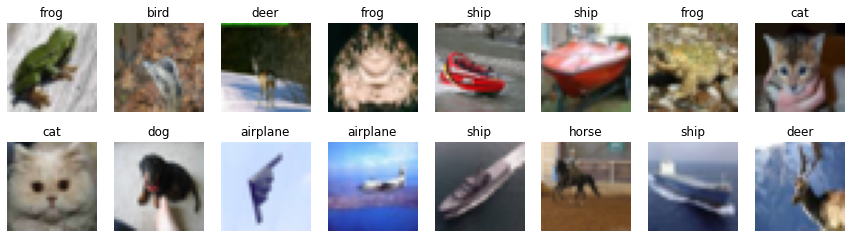

In [5]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Prepare data

* normalize the input like $x_{\text{norm}} = \frac{x}{255} - 0.5$
* We need to convert class labels to one-hot encoded vectors. Use `keras.utils.to_categorical`.

In [6]:
X_train = X_train / 255 - 0.5
X_val = X_val / 255 - 0.5
X_test = X_test / 255 - 0.5

# Define CNN architecture

In [9]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
import keras.layers as L
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and ReLU activation
* 3x3 pooling (or set previous convolution stride to 3)
* Dense layer with 100-neurons and ReLU activation
* 10% dropout
* Output dense layer.

You need to define a model which takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```


Train it with Adam optimizer with default params.


### Second step (after you've trained it)

* Add batch_norm (with default params) between convolution and pooling

Re-train the network with the same optimizer


In [8]:
def make_micro_model():
    model = Sequential(name='micro')
    model.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(3, 3),
                     filters=10, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(L.Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(NUM_CLASSES))
    return model

In [9]:
def make_mini_model():
    model = Sequential(name='mini')
    model.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(3, 3),
                     filters=10, padding='valid'))
    model.add(L.BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(L.Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(NUM_CLASSES))
    return model

In [10]:
def make_model():
    # creating model with functional API
    # creating resnet style model
    # h * w * c := height * width * channels
    inp = L.Input(shape=[32, 32, 3])
    x = inp
    x1 = L.Conv2D(filters=32, kernel_size=(3, 3),
                 padding='same')(x)
    z = L.BatchNormalization()(x1)
    z = L.Activation('relu')(z)
    z = L.Conv2D(filters=64, kernel_size=(3, 3),
                 padding='same')(z)
    z = L.BatchNormalization()(z)
    z = L.Activation('relu')(z)
    z = L.MaxPool2D()(z) # 16 * 16 * 64
    x1 = L.MaxPool2D()(x1) # 16 * 16 * 32 to match z's h * w
    z = z + tf.concat([x1, x1], axis=-1) # to match z's shape
    x2 = L.Conv2D(filters=128, kernel_size=(3, 3),
                 padding='same')(z)
    z = L.BatchNormalization()(x2)
    z = L.Activation('relu')(z)
    z = L.Conv2D(filters=160, kernel_size=(3, 3),
                 padding='same')(z)
    z = L.BatchNormalization()(z)
    z = L.Activation('relu')(z)
    z = L.MaxPool2D()(z) # 8 * 8 * 160
    x1 = L.MaxPool2D()(x1) # 8 * 8 * 32 to match z's h * w
    x2 = L.MaxPool2D()(x2) # 8 * 8 * 128 to match z's h * w
    z = z + tf.concat([x1, x2], axis=-1)# to match z's shape
    x3 = L.Conv2D(filters=192, kernel_size=(3, 3),
                 padding='same')(z)
    z = L.BatchNormalization()(x3)
    z = L.Activation('relu')(z)
    z = L.Conv2D(filters=352, kernel_size=(3, 3),
                 padding='same')(z)
    z = L.BatchNormalization()(z)
    z = L.Activation('relu')(z)
    z = L.MaxPool2D()(z) # 4 * 4 * 352
    x1 = L.MaxPool2D()(x1) # 4 * 4 * 32 to match z's h * w
    x2 = L.MaxPool2D()(x2) # 4 * 4 * 128 to match z's h * w
    x3 = L.MaxPool2D()(x3) # 4 * 4 * 192 to match z's h * w
    z = z + tf.concat([x1, x2, x3], axis=-1) # to match z's shape
    z = L.MaxPool2D()(z) # 2 * 2 * 352
    z = L.Flatten()(z) # to connect to dense layer
    z = L.Dropout(0.5)(z)
    z = L.Dense(units=144, 
                kernel_regularizer=keras.regularizers.l2(l2=1e-4))(z)
    z = L.BatchNormalization()(z)
    z = L.Activation('relu')(z)
    z = L.Dropout(0.5)(z)
    z = L.Dense(units=NUM_CLASSES,
                kernel_regularizer=keras.regularizers.l2(l2=1e-4))(z)
    net = keras.Model(inputs=inp, outputs=z)
    print(net.summary())
    net = Sequential(net)
    
    return net

# Train model

Training of your model can take approx. 4-8 minutes per epoch.

During training you should observe the decrease in reported loss on training and validation.

If the loss on training is not decreasing with epochs you should revise your model definition and learning rate.

# Evaluate model

In [13]:
# describe model
# K.clear_session()  # clear default graph
INIT_LR = 0.01  # initial learning rate
BATCH_SIZE = 50
EPOCHS = 50
# Sparse for one-hot encodeing and from_logits for softmax
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer = keras.optimizers.Adam(lr=INIT_LR)  # for SGD
early_stop = EarlyStopping(monitor='val_acc',
                           patience=10, 
                          restore_best_weights=True)

Model: "micro"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 101,390
Trainable params: 101,390
Non-trainable params: 0
_______________________________________________________

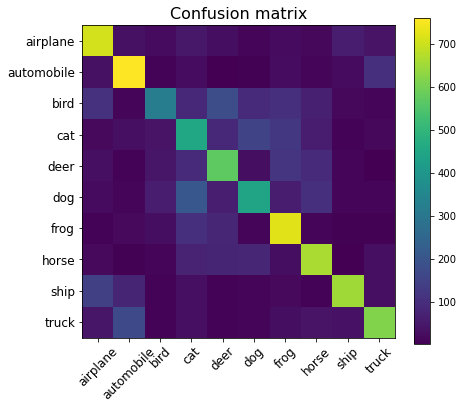

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test accuracy: 0.5908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

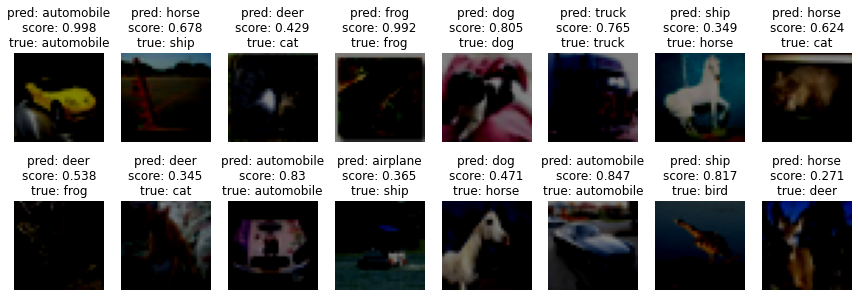

Model: "mini"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 10)        40        
_________________________________________________________________
activation (Activation)      (None, 30, 30, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               100100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0      

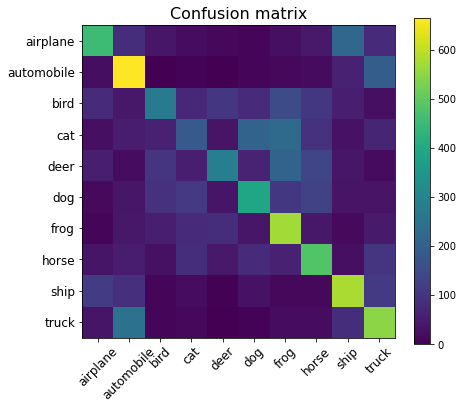

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test accuracy: 0.4446


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

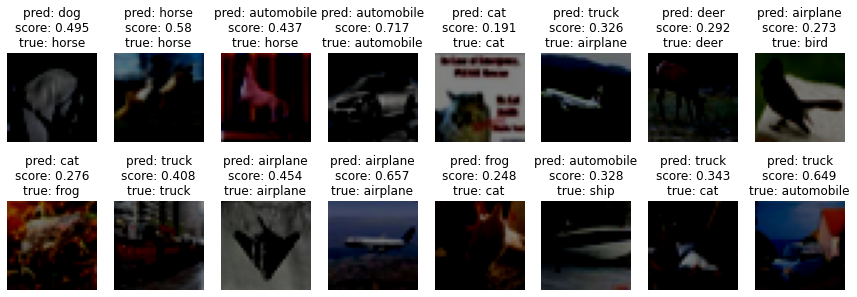

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

Epoch 1/50
800/800 [==============================] - 15s 17ms/step - loss: 2.7588 - acc: 0.2578 - val_loss: 1.6472 - val_acc: 0.4470
Epoch 2/50
800/800 [==============================] - 14s 17ms/step - loss: 1.6962 - acc: 0.4176 - val_loss: 1.3934 - val_acc: 0.5491
Epoch 3/50
800/800 [==============================] - 14s 17ms/step - loss: 1.5085 - acc: 0.5053 - val_loss: 1.2568 - val_acc: 0.5917
Epoch 4/50
800/800 [==============================] - 14s 18ms/step - loss: 1.3571 - acc: 0.5705 - val_loss: 1.1590 - val_acc: 0.6426
Epoch 5/50
800/800 [==============================] - 14s 17ms/step - loss: 1.2824 - acc: 0.6045 - val_loss: 1.0419 - val_acc: 0.6909
Epoch 6/50
800/800 [==============================] - 13s 17ms/step - loss: 1.2234 - acc: 0.6260 - val_loss: 1.0530 - val_acc: 0.6879
Epoch 7/50
800/800 [==============================] - 13s 17ms/step - loss: 1.1671 - acc: 0.6480 - val_loss: 0.9960 - val_acc: 0.7024
Epoch 8/50
800/800 [==============================] - 14s 17ms

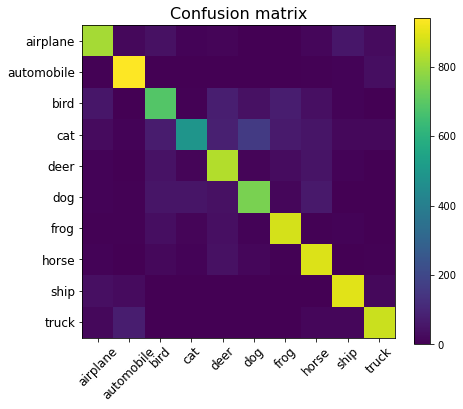

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test accuracy: 0.8046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

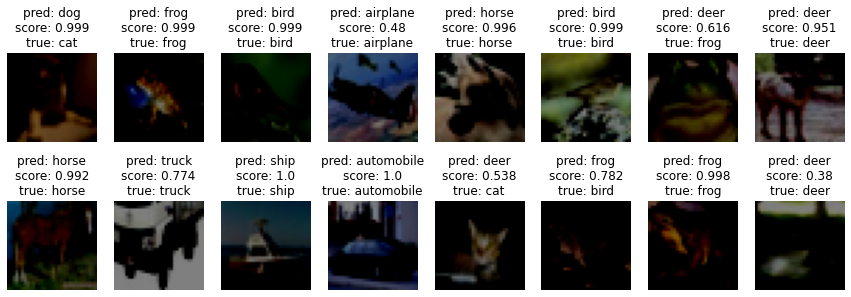

In [11]:
for model_name in ['micro_model', 'mini_model', 'model']:
    model = eval('make_' + model_name)()
    model.summary()

    # prepare model for fitting (loss, optimizer, etc)
    model.compile(
        loss=loss,
        optimizer=optimizer,  # for SGD
        metrics=['acc']  # report accuracy during training
    )

    # fit model
    model.fit(
        X_train, y_train,  # prepared data
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        shuffle=True, 
        callbacks=[early_stop]
    )
    
    # load weights from file (can call without model.fit)
    model.save_weights(f"{model_name}_weights.h5")
    model.load_weights(f"{model_name}_weights.h5")
    
    # make test predictions
    y_pred_test = model.predict_proba(X_test)
    y_pred_test_classes = np.argmax(y_pred_test, axis=-1)
    y_pred_test_max_probas = np.max(tf.math.softmax(y_pred_test, axis=-1), axis=-1)
    
    # confusion matrix and accuracy
    plt.figure(figsize=(7, 6))
    plt.title('Confusion matrix', fontsize=16)
    plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
    plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
    plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
    plt.colorbar()
    plt.show()
    print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))
    
    # inspect preditions
    cols = 8
    rows = 2
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(y_test))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(X_test[random_index, :])
            pred_label = cifar10_classes[y_pred_test_classes[random_index]]
            pred_proba = y_pred_test_max_probas[random_index]
            true_label = cifar10_classes[y_test[random_index, 0]]
            ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
                   pred_label, pred_proba, true_label
            ))
    plt.show()

# Main: Quest For A Better Network

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

## Bonus points

Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example "A super-small/fast NN that gets 80%" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets. After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([keras docs](https://keras.io/))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
    `                        num_filters = n_neurons,`
    `                        filter_size = (filter width, filter height),`
    `                        nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   * Plenty other layers and architectures
     * https://keras.io/layers/writing-your-own-keras-layers/
     * batch normalization, pooling, etc

 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - https://keras.io/regularizers/
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
   
   
   
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way